In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

OBSV_DATES_APERS = {
    datetime.date(year=2022, month=10, day=21).strftime("%Y-%m-%d"): 10,
    datetime.date(year=2022, month=10, day=27).strftime("%Y-%m-%d"): 9,
    datetime.date(year=2022, month=11, day=5).strftime("%Y-%m-%d"): 10,
    datetime.date(year=2022, month=11, day=26).strftime("%Y-%m-%d"): 11,
    datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d"): 11,
    datetime.date(year=2022, month=12, day=7).strftime("%Y-%m-%d"): 16,
    datetime.date(year=2022, month=12, day=9).strftime("%Y-%m-%d"): 18,
    datetime.date(year=2022, month=12, day=10).strftime("%Y-%m-%d"): 10,
}

# OBJ_DATA_DIR = "/run/media/ramon/USBD/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"
OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

QPHOT_DATA_DIRS = [os.path.join(OBJ_DATA_DIR, d, "corrected", "iraf-shifted", "qphot-results") for d in OBSV_DATES_APERS.keys()]
for qphotDir in QPHOT_DATA_DIRS:
    assert os.path.exists(qphotDir), f"{qphotDir} not found"

QPHOT_DATA_DIRS

['/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-21/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-27/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-05/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-26/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-07/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-09/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-10/corrected/iraf-shifted/qphot-results']

In [18]:
import pandas as pd
pd.set_option("display.max_columns", None)

import numpy as np
from scipy import stats
from astropy.io import ascii

allObjDf = pd.DataFrame()
for (obsvDate, rapert), qphotDir in zip(OBSV_DATES_APERS.items(), QPHOT_DATA_DIRS):
    qphotResults = ascii.read(os.path.join(qphotDir, "phot")).to_pandas()
    qphotResults = qphotResults[qphotResults['LID'] == 1]
    qphotResults['OTIME'] = pd.to_datetime(qphotResults['OTIME'])
    print(obsvDate, f"Aperture: {rapert}\tObservations: {len(qphotResults)}")

    apertureCols = [c for c in qphotResults.columns if c.startswith('RAPERT')]
    apertureIds = [c[-1] for c in apertureCols]
    for apCol in apertureCols:
        colRadius = qphotResults.loc[qphotResults.index[0], apCol]
        if colRadius == rapert:
            apertureCols.remove(apCol)
            apId = apCol.replace("RAPERT", "")
            apertureIds.remove(apId)
            qphotResults.drop(columns=[c for c in qphotResults.columns if c[-1] in apertureIds], inplace=True)
            renamedCols = {colName:colName[:-1] for colName in qphotResults.columns if colName.endswith(apId) }
            qphotResults.rename(columns=renamedCols, inplace=True)
            break
    EPADU = 10.0
    qphotResults['err'] = np.sqrt(
                                    (qphotResults['FLUX']/EPADU) 
                                       + (qphotResults['AREA']*qphotResults['STDEV']**2)
                                       + ((qphotResults['AREA']**2) 
                                          * ((qphotResults['STDEV']**2)/qphotResults['NSKY']))
                                )
    
    qphotResults = qphotResults[(np.abs(stats.zscore(qphotResults['MAG'], nan_policy='omit')) < 2)]
    qphotResults['obsv_date'] = obsvDate
    allObjDf = pd.concat([allObjDf, qphotResults], ignore_index=True)

allObjDf.to_csv(f"{OBJ_DATA_DIR}/irafObjectConcatResults.csv")
allObjDf

2022-10-21 Aperture: 10	Observations: 147
2022-10-27 Aperture: 9	Observations: 114
2022-11-05 Aperture: 10	Observations: 119
2022-11-26 Aperture: 11	Observations: 72
2022-12-06 Aperture: 11	Observations: 286
2022-12-07 Aperture: 16	Observations: 218
2022-12-09 Aperture: 18	Observations: 140
2022-12-10 Aperture: 10	Observations: 125


,IMAGE,XINIT,YINIT,ID,COORDS,LID,XCENTER,YCENTER,XSHIFT,YSHIFT,XERR,YERR,CIER,CERROR,MSKY,STDEV,SSKEW,NSKY,NSREJ,SIER,SERROR,ITIME,XAIRMASS,IFILTER,OTIME,RAPERT,SUM,AREA,FLUX,MAG,MERR,PIER,PERROR,err,obsv_date
0,s_bdf_2022-10-21_22-54-,958.0,597.87,1,coords,1,958.751,598.943,0.751,1.073,0.009,0.009,107,BigShift,134.9789,25.70022,11.685880,2967,88,0,NoError,60.0,1.077095,Luminance,2022-10-21 22:54:21.841,10.0,79804.84,314.2922,37382.02,18.014,0.014,0,NoError,483.030554,2022-10-21
1,s_bdf_2022-10-21_22-55-,958.0,597.87,4,coords,1,958.878,599.123,0.878,1.253,0.009,0.009,107,BigShift,130.3998,20.68318,9.598464,2964,102,0,NoError,60.0,1.077624,Luminance,2022-10-21 22:55:22.219,10.0,77354.34,314.3964,36357.11,18.044,0.012,0,NoError,390.383005,2022-10-21
2,s_bdf_2022-10-21_22-56-,958.0,597.87,7,coords,1,958.631,598.916,0.631,1.046,0.009,0.009,107,BigShift,130.2290,23.86399,11.933590,2973,89,0,NoError,60.0,1.078175,Luminance,2022-10-21 22:56:22.714,10.0,78163.05,314.4327,37214.78,18.019,0.013,0,NoError,449.139519,2022-10-21
3,s_bdf_2022-10-21_22-57-,958.0,597.87,10,coords,1,958.863,598.939,0.863,1.069,0.010,0.010,107,BigShift,130.2679,18.28773,9.044432,2952,112,0,NoError,60.0,1.078740,Luminance,2022-10-21 22:57:23.081,10.0,78603.63,314.4248,37644.18,18.006,0.010,0,NoError,346.585443,2022-10-21
4,s_bdf_2022-10-21_22-58-,958.0,597.87,13,coords,1,958.985,598.830,0.985,0.960,0.010,0.011,0,NoError,129.6885,16.51644,8.085767,2940,118,0,NoError,60.0,1.079317,Luminance,2022-10-21 22:58:23.606,10.0,77430.43,314.3319,36665.20,18.035,0.009,0,NoError,313.977292,2022-10-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,s_bdf_2022-12-10_20-52-,961.5,595.25,361,coords,1,962.701,596.447,1.201,1.197,0.010,0.009,107,BigShift,463.4224,20.45449,-4.113526,1570,3,0,NoError,60.0,1.308070,Luminance,2022-12-10 20:52:39.875,10.0,175034.00,314.4213,29324.09,18.277,0.015,0,NoError,401.032585,2022-12-10
1173,s_bdf_2022-12-10_20-53-,961.5,595.25,364,coords,1,963.152,596.373,1.652,1.123,0.011,0.010,107,BigShift,463.1632,25.54925,-5.848438,1559,6,0,NoError,60.0,1.310825,Luminance,2022-12-10 20:53:40.007,10.0,175240.00,314.4243,29610.24,18.267,0.018,0,NoError,499.600260,2022-12-10
1174,s_bdf_2022-12-10_20-54-,961.5,595.25,367,coords,1,962.850,596.484,1.350,1.234,0.011,0.009,107,BigShift,469.0698,31.30728,15.018900,1567,4,0,NoError,60.0,1.314658,Luminance,2022-12-10 20:54:40.156,10.0,175974.40,314.5850,28412.02,18.312,0.023,0,NoError,610.803870,2022-12-10
1175,s_bdf_2022-12-10_20-55-,961.5,595.25,370,coords,1,962.720,596.491,1.220,1.241,0.009,0.008,107,BigShift,472.1415,22.49104,7.755672,1559,15,0,NoError,60.0,1.318018,Luminance,2022-12-10 20:55:40.318,10.0,176083.00,314.4729,27607.31,18.343,0.017,0,NoError,440.367605,2022-12-10


In [32]:
jdDate = allObjDf['OTIME'].map(lambda d: d.to_julian_date())
jdDate

0       2.459874e+06
1       2.459874e+06
2       2.459874e+06
3       2.459874e+06
4       2.459874e+06
            ...     
1172    2.459924e+06
1173    2.459924e+06
1174    2.459924e+06
1175    2.459924e+06
1176    2.459924e+06
Name: OTIME, Length: 1177, dtype: float64

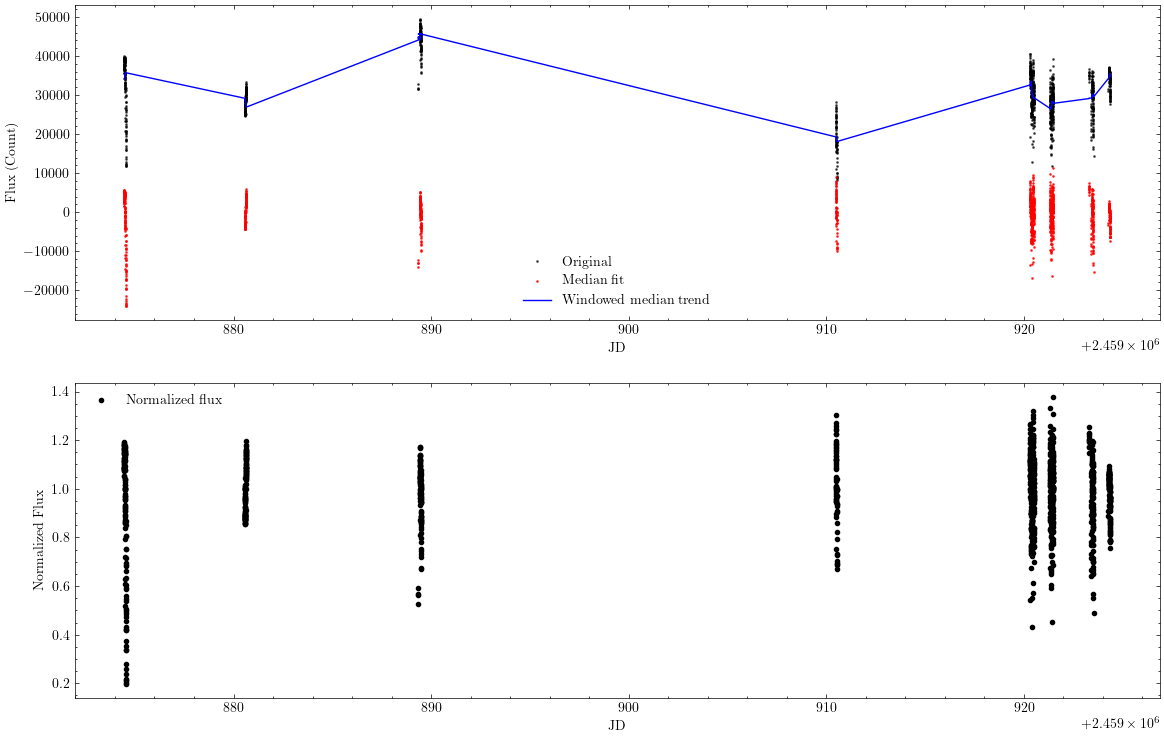

In [19]:
%matplotlib widget

import astropy.units as u
from scipy.ndimage import median_filter
from astropy.timeseries import TimeSeries

def medianFilterByDate(obsvDate: str):
    dateData = allObjDf[allObjDf['obsv_date'] == obsvDate].copy()
    trend = median_filter(dateData['FLUX'], size=301, mode='mirror')
    dateData['FLUX'] -= trend
    return (dateData, trend)

normalizedDf = pd.concat([medianFilterByDate(d)[0] for d in allObjDf['obsv_date'].unique()], ignore_index=True)
trend = np.concatenate([medianFilterByDate(d)[1] for d in allObjDf['obsv_date'].unique()])

normalizedTs = TimeSeries(time=allObjDf['OTIME'], 
            data={'mag': normalizedDf['MAG']*u.mag, 'err': normalizedDf['MERR']*u.mag, 
                  'raw_flux': allObjDf['FLUX']*u.ct, 'ferr': normalizedDf['err'], 
                  'detrend_flux': normalizedDf['FLUX']*u.ct, 
                  'norm_flux': (normalizedDf['FLUX'] + np.median(trend)) / np.median(trend),
                  'obsv_date': normalizedDf['obsv_date'], 
                  'julianDate': allObjDf['OTIME'].map(lambda d: d.to_julian_date())})

normalizedTs.to_pandas().to_csv(f"{OBJ_DATA_DIR}/normalizedTimeseries.csv")

figure, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 9))
axs[0].plot(normalizedTs.time.jd, normalizedTs['raw_flux'], 'k.', markersize=2, label="Original", alpha=0.6)
axs[0].plot(normalizedTs.time.jd, normalizedTs['detrend_flux'], 'r.', markersize=2, label="Median fit", alpha=0.7)
axs[0].plot(normalizedTs.time.jd, trend, color='blue', label="Windowed median trend")
axs[0].set_ylabel("Flux (Count)")
axs[0].set_xlabel("JD")
axs[0].legend()

axs[1].plot(normalizedTs.time.jd, normalizedTs['norm_flux'], 'k.', label='Normalized flux')
axs[1].set_ylabel("Normalized Flux")
axs[1].set_xlabel("JD")
axs[1].legend()

plt.show()

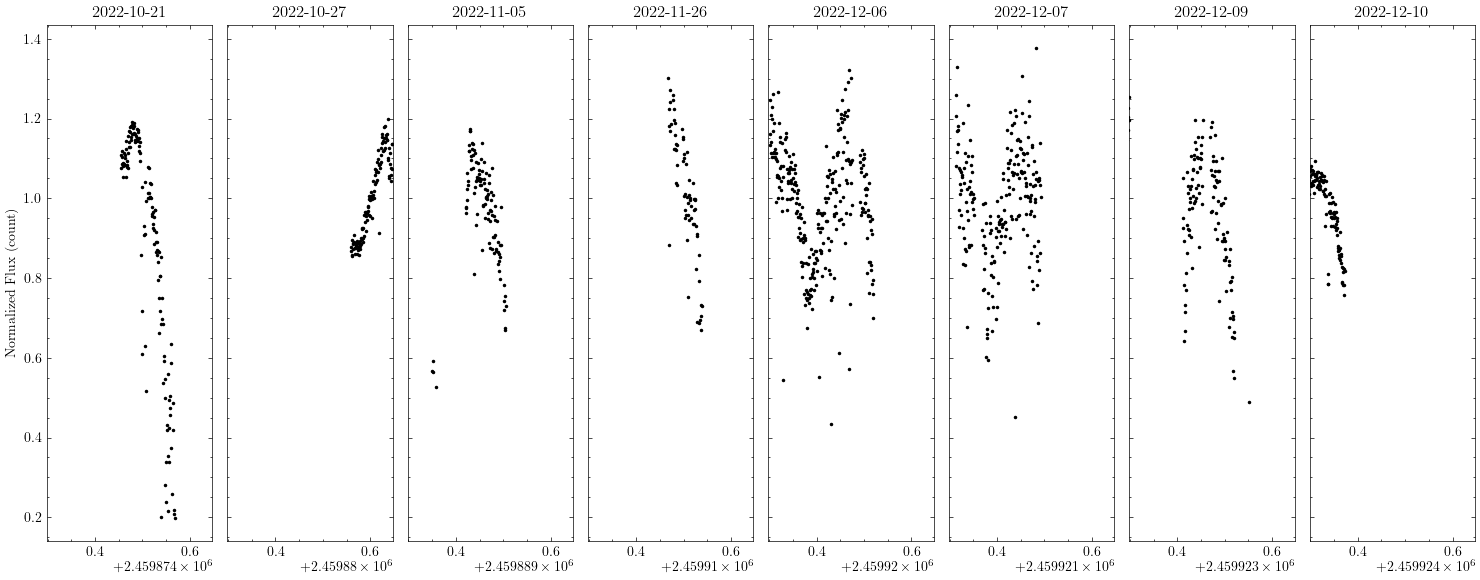

In [7]:
# normalized flux

%matplotlib widget

import astropy.units as u
import numpy as np
from astropy.timeseries import TimeSeries
from astropy.time import Time

tsObsvDates = allObjDf['obsv_date'].unique()
fig, axs = plt.subplots(nrows=1, ncols=len(tsObsvDates), sharey=True, figsize=(15, 6))

for d, ax in zip(tsObsvDates, axs):
    dateTs = normalizedTs[normalizedTs['obsv_date'] == d]
    ax.plot(normalizedTs.time.jd, normalizedTs['norm_flux'], 'k.', markersize=3)

    baseMinDayTime = Time(f"{dateTs['obsv_date'][0]}T19:10:00", format='isot', scale='utc')
    baseMaxDayTime = Time(f"{dateTs['obsv_date'][0]}T03:32:00", format='isot', scale='utc') + 1*u.day

    ax.set_xlim(baseMinDayTime.jd, baseMaxDayTime.jd)
    
    ax.set_title(d)

axs[0].set_ylabel("Normalized Flux (count)")
fig.tight_layout()

Text(0, 0.5, 'Duration [h]')

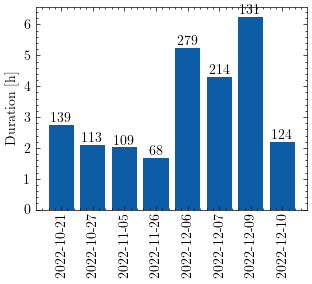

In [10]:
# observation duration bar chart

%matplotlib widget

import numpy as np

tsObsvDates = allObjDf['obsv_date'].unique()
obsvDatesDurations = []
obsvCounts = []
for i, d in enumerate(tsObsvDates):
    obsvData = allObjDf[allObjDf['obsv_date'] == d]
    obsvStart = obsvData['OTIME'].iloc[0]
    obsvEnd = obsvData['OTIME'].iloc[-1]
    durationHours = (obsvEnd - obsvStart).seconds / 3600
    obsvDatesDurations.append(durationHours)
    obsvCounts.append(len(obsvData))

fig, ax = plt.subplots()
ax.bar(np.arange(len(tsObsvDates)), obsvDatesDurations)

rects = ax.patches
for rect, label in zip(rects, obsvCounts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")

ax.set_xticks(np.arange(len(tsObsvDates)), tsObsvDates, rotation='vertical')
ax.set_ylabel("Duration [h]")

Periodo: 3.415962280325761 h
Frecuencia: 7.0258387038487005 1 / d


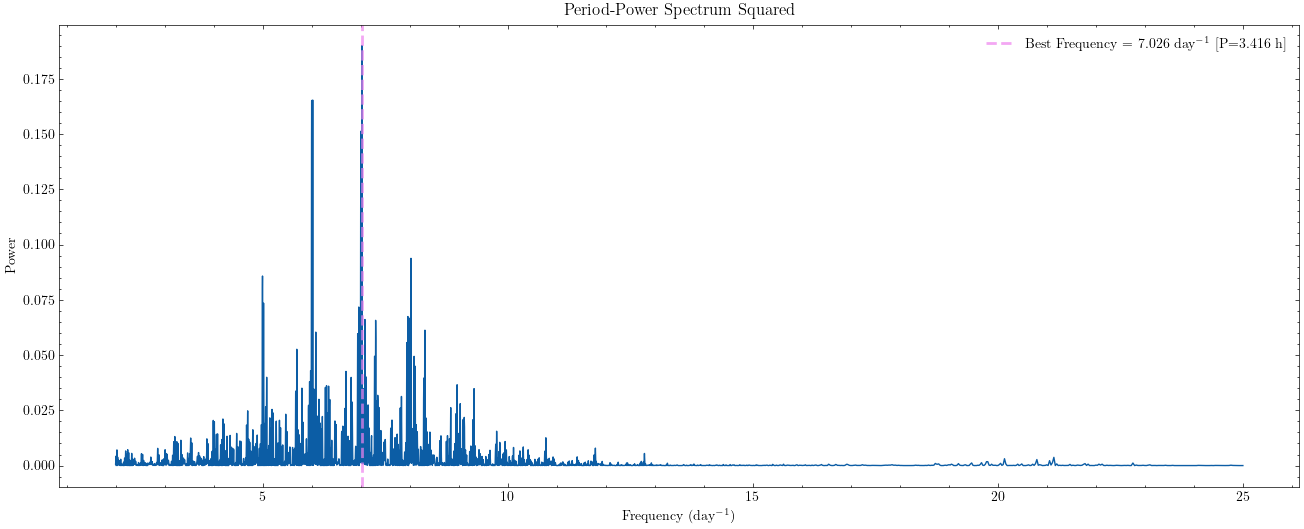

In [35]:
%matplotlib widget

import astropy.units as u
from astropy.timeseries import BoxLeastSquares, LombScargle

# copyTs = objTimeSeries.copy()
# trend = median_filter(copyTs['flux'], size=151, mode='nearest')
# copyTs['flux'] = (copyTs['flux'] - (trend*u.ct)) + np.median(objTimeSeries['flux'])
# copyTs['flux'] = copyTs['flux'] - (trend*u.ct)
# trend = medfilt(copyTs['mag'], 191)
# copyTs['mag'] = (copyTs['mag'] - (trend*u.mag)) + np.median(objTimeSeries['mag'])

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

# axs[0].plot(objTimeSeries.time_bin_start.jd, objTimeSeries['flux'], 'k.', markersize=3, label="Original")
# axs[0].plot(copyTs.time_bin_start.jd, copyTs['flux'], 'r.', markersize=3, label="Median fit")

# axs[0].plot(objTimeSeries.time_bin_center.jd, objTimeSeries['mag'], 'k.', markersize=3, label="Original", alpha=0.6)
# axs[0].plot(copyTs.time_bin_center.jd, copyTs['mag'], 'r.', markersize=3, label="Median fit")
# axs[0].plot(copyTs.time_bin_center.jd, trend, color='blue', label="Windowed median trend")

# axs[0].plot(objTimeSeries.time.jd, objTimeSeries['mag'], 'k.', markersize=3, label="Original", alpha=0.6)
# axs[0].plot(copyTs.time.jd, copyTs['mag'], 'r.', markersize=3, label="Median fit", alpha=0.7)

# axs[0].plot(objTimeSeries.time.jd, objTimeSeries['flux'], 'k.', markersize=3, label="Original", alpha=0.6)
# axs[0].plot(copyTs.time.jd, copyTs['flux'], 'r.', markersize=3, label="Median fit", alpha=0.7)

# axs[0].plot(copyTs.time.jd, trend, color='blue', label="Windowed median trend")

# model = BoxLeastSquares.from_timeseries(copyTs, signal_column_name="mag", uncertainty="err")
# model = BoxLeastSquares.from_timeseries(objTimeSeries, signal_column_name="mag", uncertainty="err")

# model = BoxLeastSquares.from_timeseries(normalizedTs, signal_column_name="flux")
# transitDurationsTest = np.linspace(0.005, 0.03, 50)*u.day
# periods = np.linspace(0.04, 0.4, 5000)*u.d
# explicitPeriodogram = model.power(periods, transitDurationsTest)
# bestPeriod = explicitPeriodogram.period[np.argmax(explicitPeriodogram.power)]
# ax.plot(explicitPeriodogram.period, np.power(explicitPeriodogram.power, 2))
# ax.axvline(bestPeriod.value, color='violet', linestyle='--', label=f"Best Period = {bestPeriod.value:0.3f} day$^{{-1}}$", linewidth=2, alpha=0.7)

# TODO: explore Lomb-Scargle periodogram some more
periods = np.linspace(0.04, 0.5, 7000)*u.d
model = LombScargle.from_timeseries(normalizedTs, signal_column_name='norm_flux')
freqs = 1.0 / periods
explicitPeriodogram = model.power(freqs)
bestFreq = freqs[np.argmax(explicitPeriodogram)]
bestPeriod = 1.0 / bestFreq
ax.plot(freqs, np.power(explicitPeriodogram, 2))
ax.axvline(bestFreq.value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} day$^{{-1}}$ [P={bestPeriod.to(u.hour):0.3f}]", linewidth=2, alpha=0.7)
# ax.axvline(bestFreq.value*2, color='indigo', linestyle='--', label=f"Best Frequency (2nd harmonic) = {bestFreq.value*2:0.3f} day$^{{-1}} [$P={bestPeriod.to(u.hour)*2:0.3f}$]$", linewidth=2, alpha=0.7)

ax.set_title("Period-Power Spectrum Squared")
ax.set_xlabel("Frequency (day$^{-1}$)")
ax.set_ylabel("Power")

ax.legend()
print(f"Periodo: {bestPeriod.to(u.hour)}")
print(f"Frecuencia: {1.0 / bestPeriod}")

In [7]:
%%script echo "skipping for LS"

index = np.argmax(explicitPeriodogram.power)

period = explicitPeriodogram.period[index]
transitTime = explicitPeriodogram.transit_time[index]
transitDuration = explicitPeriodogram.duration[index]

periodogramStats = model.compute_stats(period, transitDuration, transitTime)
periodogramStats

skipping for LS


In [8]:
%%script echo "skipping for LS"

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

ax.plot(objTimeSeries.time.jd, objTimeSeries['flux'], 'k.', markersize=3, label="Original")

i = 0
for tt in periodogramStats['transit_times']:
    if periodogramStats['per_transit_count'][i] != 0 or i % 5 == 0:
        lineColor = "blue" if periodogramStats['per_transit_count'][i] != 0 else "orange"
        ax.axvline(tt.jd, linestyle='--', color=lineColor, alpha=0.5)
    i = i + 1

skipping for LS


137


Text(0, 0.5, 'Normalized Flux')

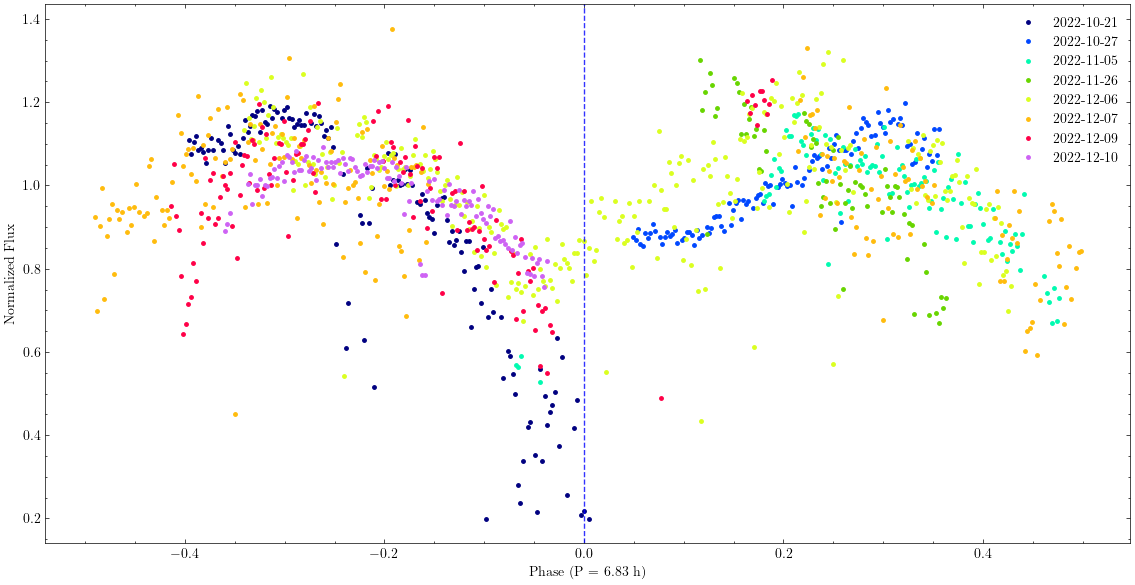

In [27]:
import numpy as np
from matplotlib import cm

# period = 0.124*u.day
periodHarmonic = 2
period = bestPeriod*periodHarmonic

tsObsvDates = allObjDf['obsv_date'].unique()

cmap = cm.get_cmap('gist_ncar')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(OBSV_DATES_APERS), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
# foldedTs = objTimeSeries.fold(period=period, epoch_time=transitTime, normalize_phase=True)
# minIndex = np.argmin(normalizedTs[normalizedTs['obsv_date'] == tsObsvDates[5]]['raw_flux'])
minIndex = np.argmin(normalizedTs[normalizedTs['obsv_date'] == tsObsvDates[5]]['raw_flux'])
print(minIndex)
foldedTs = normalizedTs.fold(period=period, epoch_time=normalizedTs.time[minIndex], normalize_phase=True)
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.plot(obsvPoints.time.value, obsvPoints['norm_flux'], '.', color=color, markersize=5, label=obsvDate)
ax.legend()
ax.axvline(0, linestyle='--', color='blue', alpha=0.8)

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)")
ax.set_ylabel("Normalized Flux")